In [75]:
! pip install seaborn

     |████████████████████████████████| 215kB 10.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [101]:
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt
import torch.utils.data as data
import torch
from torch.nn.modules import loss
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import seaborn
seaborn.set(style="dark")

In [115]:
seed = 761
torch.manual_seed(seed)

In [153]:
with open("mnist-hw1.pkl", 'rb') as f:
    data = pickle.load(f)
    
train_dataset = data['train']
val_dataset = data['test']

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))

dim = train_dataset[0].shape[0] # 28

Train size: 60000
Validation size: 10000


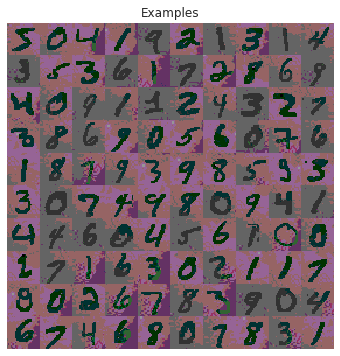

In [117]:
ind = 0
num_elems = 10
rgb = 3

examples = np.zeros((dim * num_elems, num_elems * dim, rgb), dtype=int)

for i in range(num_elems):
    for j in range(num_elems):
        examples[i * dim : (i + 1) * dim, j * dim : (j + 1) * dim, ] = train_dataset[ind] * 50
        ind += 1

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(examples)
plt.title('Examples')
plt.show()

In [154]:
length, height, width, rgb_colors = 0, 1, 2, 3
train_dataset = torch.LongTensor(train_dataset).permute(length, rgb_colors, height, width)
val_dataset = torch.LongTensor(val_dataset).permute(length, rgb_colors, height, width)

In [120]:
EPS = 1e-9

class MyMaskConv2d(nn.Conv2d):
    def __init__(self, mask_label, in_channels, out_channels, kernel_size, padding):
        super(MyMaskConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)
        wshape = self.weight.shape
        self.mask = torch.ones(wshape).cuda()
        bt = (mask_label == 'b')
        self.mask[:, :, wshape[2] // 2, wshape[3] // 2 + bt:] = 0
        self.mask[:, :, wshape[2] // 2 + 1:] = 0

    def forward(self, input):
        self.weight.data *= self.mask
        return super(MyMaskConv2d, self).forward(input)
    
class MyResidualBlock(nn.Module):
    def __init__(self, channels=32):
        super(MyResidualBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            MyMaskConv2d('b', channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, 2 * channels, 1),
            nn.BatchNorm2d(2 * channels)
        )

    def forward(self, input):
        return self.layers(input) + input

class PixelCNN(nn.Module):
    def __init__(self, channels):
        super(PixelCNN, self).__init__()

        self.layers = nn.Sequential(
            MyMaskConv2d('a', 3, 2 * channels, 7, 1, 3),
            *[MyResidualBlock() for i in range(12)],
            nn.ReLU(),
            nn.Conv2d(2 * channels, 2 * channels, 1),
            nn.BatchNorm2d(2 * channels),
            nn.ReLU(),
            nn.Conv2d(2 * channels, 12, 1)
        )

    def forward(self, x):
        out = self.layers(x.float())
        out = output.reshape(x.shape[0], x.shape[1], 4, x.shape[2], x.shape[3]).permute(0, 1, 3, 4, 2)
        return out

def NLL_loss(out, ref):
    out = F.softmax(out, dim=-1)
    ref = F.one_hot(ref, 4).float()
    return -torch.log((out * ref).sum(dim=-1) + EPS).mean()

In [186]:
NUM_EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-3
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [187]:
model = PixelCNN()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0)
global_step = 0
train_steps, train_losses, val_steps, val_losses = [], [], [], []

model.eval()
cnt = 0
sum_losses = 0
with torch.no_grad():
    for batch in val_loader:
        cnt += 1
        batch = batch.cuda()
        output = model(batch)
        loss = NLL_loss(output, batch)
        sum_losses += loss.item()
val_steps.append(global_step)
val_losses.append(sum_losses / cnt)

for i in range(NUM_EPOCHS):
    losses = []
    model.train()
    for batch in train_loader:
        global_step += 1
        batch = batch.cuda()
        optimizer.zero_grad()
        output = model(batch)
        loss = NLL_loss(output, batch)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        train_steps.append(global_step)
        train_losses.append(loss.item())
    print(f'Epoch: {i} Loss: {train_losses[-1]}')

    model.eval()
    cnt = 0
    sum_losses = 0
    with torch.no_grad():
        for batch in val_loader:
            cnt += 1
            batch = batch.cuda()
            output = model(batch)
            loss = NLL_loss(output, batch)
            sum_losses += loss.item()
    val_steps.append(global_step)
    val_losses.append(sum_losses / cnt)

print(f"Final Val Loss: {val_losses[-1]}")

Epoch: 0 Loss: 0.1635439395904541
Epoch: 1 Loss: 0.13206040859222412
Epoch: 2 Loss: 0.11328322440385818
Epoch: 3 Loss: 0.11096321046352386
Epoch: 4 Loss: 0.10730952769517899
Epoch: 5 Loss: 0.10182658582925797
Epoch: 6 Loss: 0.10336555540561676
Epoch: 7 Loss: 0.10611927509307861
Epoch: 8 Loss: 0.10012298822402954
Epoch: 9 Loss: 0.09976005554199219
Epoch: 10 Loss: 0.09808112680912018
Epoch: 11 Loss: 0.09650421142578125
Epoch: 12 Loss: 0.09487983584403992
Epoch: 13 Loss: 0.1009223610162735
Epoch: 14 Loss: 0.09879868477582932
Epoch: 15 Loss: 0.09621129930019379
Epoch: 16 Loss: 0.09913934022188187
Epoch: 17 Loss: 0.09649261087179184
Epoch: 18 Loss: 0.09596667438745499
Epoch: 19 Loss: 0.09765273332595825
Final Val Loss: 0.09642267679866356


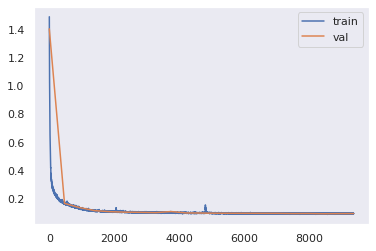

In [188]:
plt.plot(train_steps, train_losses, label="train")
plt.plot(val_steps, val_losses, label="val")
plt.legend()
plt.show()

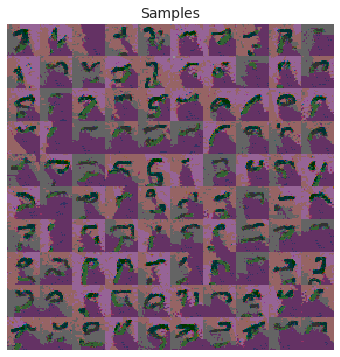

In [189]:
model.eval()
samples = np.zeros((100, 28, 28, 3), dtype=np.uint8)
for y in range(28):
    for x in range(28):
        for c in range(3):
            with torch.no_grad():
                in_samples = torch.LongTensor(samples).permute(length, rgb_colors, height, width).cuda()
                out = model(in_samples)
                probs = F.softmax(out, dim=4).cpu().numpy()
            for i in range(100):
                samples[i, y, x, c] = np.random.choice(4, p=probs[i, c, y, x])    
num_elems = 10
rgb = 3
n = 10

examples = np.zeros((dim * num_elems, num_elems * dim, rgb), dtype=int)

for k, img in enumerate(samples):
    i = k // n
    j = k % n
    examples[i * dim : (i + 1) * dim, j * dim : (j + 1) * dim, ] = img * 50

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(examples)
plt.title('Samples', fontsize=14)
plt.show()

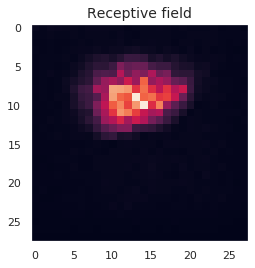

In [159]:
smpl = val_dataset[:5]
inpt = torch.tensor(smpl.numpy().astype(np.float32), requires_grad=True, device=torch.device("cuda"))
outpt = PixelCNN().cuda()(inpt)[:, 0, 14, 14]
ref = smpl[:, 0, 14, 14]
loss = NLL_loss(outpt.cpu(), ref.cpu()).backward()

im = inpt.grad.abs().sum(dim=(0, 1))
plt.imshow(im.cpu().float().numpy())
plt.title("Receptive field", fontsize=14)
plt.show()